Copyright (c) 2017-2020 [Serpent-Tools developer team](https://github.com/CORE-GATECH-GROUP/serpent-tools/graphs/contributors), GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Branching Reader
## Basic Operation

This notebook demonstrates the capability of the [`serpentTools`](https://github.com/CORE-GATECH-GROUP/serpent-tools) package to read branching coefficient files. The format of these files is structured to iterate over:

1. Branch states, e.g. burnup, material properties
1. Homogenized universes
1. Group constant data

The output files are described in more detail on the [SERPENT Wiki](http://serpent.vtt.fi/mediawiki/index.php/Automated_burnup_sequence#Output_format)

The simplest way to read these files is using the [`serpentTools.read`](http://serpent-tools.readthedocs.io/en/latest/api/parsers.html#serpentTools.parsers.read) function. Here, we will read the reference file distributed with this package by using `serpentTools.readDataFile`

**Note**

Without modifying the settings, the [`BranchingReader`](http://serpent-tools.readthedocs.io/en/latest/api/branching.html#serpentTools.parsers.branching.BranchingReader) assumes that all group constant data is presented without the associated uncertainties. See below for examples on the various ways to adjust the UserSettings

In [1]:
%matplotlib inline
import serpentTools
branchFile = 'demo.coe'

In [2]:
r0 = serpentTools.readDataFile(branchFile)

The branches are stored in custom dictionary-like [`BranchContainer`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.BranchContainer) objects in the `branches` dictionary

In [3]:
r0.branches.keys()

dict_keys([('nom', 'nom'), ('B750', 'nom'), ('B1000', 'nom'), ('nom', 'FT1200'), ('B750', 'FT1200'), ('B1000', 'FT1200'), ('nom', 'FT600'), ('B750', 'FT600'), ('B1000', 'FT600')])

Here, the keys are tuples of strings indicating what perturbations/branch states were applied for each `SERPENT` solution. Examining a particular case

In [4]:
b0 = r0.branches['B1000', 'FT600']
print(b0)

<BranchContainer for B1000, FT600 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>


`SERPENT` allows the user to define variables for each branch through:

`
var V1_name V1_value
`

cards. These are stored in the `stateData` attribute

In [5]:
b0.stateData

{'VERSION': '2.1.29',
 'DATE': '17/12/19',
 'TIME': '09:48:54',
 'BOR': '1000',
 'TFU': '600'}

The keys `'DATE'`, `'TIME'`, and `'VERSION'` are included by default in the output, while the `'BOR'` and `'TFU'` have been defined for this branch.

### Group Constant Data
**Note**: Group constants are converted from `SERPENT_STYLE` to `mixedCase` to fit the overall style of the project.

The [`BranchContainer`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.BranchContainer) stores group constant data in [`HomogUniv`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv) objects as a dictionary.

In [6]:
for key in b0:
    print(key)

UnivTuple(universe='0', burnup=0.0, step=0, days=None)
UnivTuple(universe='10', burnup=0.0, step=0, days=None)
UnivTuple(universe='20', burnup=0.0, step=0, days=None)
UnivTuple(universe='30', burnup=0.0, step=0, days=None)
UnivTuple(universe='40', burnup=0.0, step=0, days=None)
UnivTuple(universe='0', burnup=1.0, step=1, days=None)
UnivTuple(universe='10', burnup=1.0, step=1, days=None)
UnivTuple(universe='20', burnup=1.0, step=1, days=None)
UnivTuple(universe='30', burnup=1.0, step=1, days=None)
UnivTuple(universe='40', burnup=1.0, step=1, days=None)
UnivTuple(universe='0', burnup=10.0, step=2, days=None)
UnivTuple(universe='10', burnup=10.0, step=2, days=None)
UnivTuple(universe='20', burnup=10.0, step=2, days=None)
UnivTuple(universe='30', burnup=10.0, step=2, days=None)
UnivTuple(universe='40', burnup=10.0, step=2, days=None)


The keys here are `UnivTuple` instances indicating the universe ID and point in burnup schedule.
These universes can be obtained by indexing into the `BranchContainer`, or by using the [`getUniv`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.BranchContainer.getUniv) method.

In [7]:
univ0 = b0['0', 1, 1, None]
univ0

In [8]:
univ0.name, univ0.bu, univ0.step, univ0.day

('0', 1.0, 1, None)

In [9]:
univ1 = b0.getUniv('0', burnup=1)
univ2 = b0.getUniv('0', index=1)
assert univ0 is univ1 is univ2

Group constant data is spread out across sub-dictionaries:

1. [`infExp`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.infExp): Expected values for infinite medium group constants
1. [`infUnc`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.infUnc): Relative uncertainties for infinite medium group constants
1. [`b1Exp`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.b1Exp): Expected values for leakge-corrected group constants
1. [`b1Unc`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.b1Unc): Relative uncertainties for leakge-corrected group constants
1. [`gc`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.gc): Group constant data that does not match the `INF` nor `B1` scheme
1. [`gcUnc`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.gcUnc): Relative uncertainties for data in [`gc`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.gc)

For this problem, only expected values for infinite and critical spectrum (B1) group constants are returned, so only the `infExp` and `b1Exp` dictionaries contain data

In [10]:
univ0.infExp

{'infTot': array([0.310842, 0.618286]),
 'infFiss': array([0.00271604, 0.059773  ]),
 'infS0': array([0.298689  , 0.00197521, 0.00284247, 0.470054  ]),
 'infS1': array([0.0847372 , 0.00047366, 0.00062865, 0.106232  ]),
 'infDiffcoef': array([1.83961 , 0.682022])}

In [11]:
univ0.infUnc

{}

In [12]:
univ0.b1Exp

{'b1Tot': array([0.314521, 0.618361]),
 'b1Fiss': array([0.00278366, 0.0597712 ]),
 'b1S0': array([0.301766  , 0.0021261 , 0.00283866, 0.470114  ]),
 'b1S1': array([0.0856397 , 0.00051071, 0.00062781, 0.106232  ]),
 'b1Diffcoef': array([1.79892 , 0.765665])}

In [13]:
univ0.gc

{}

In [14]:
univ0.gcUnc

{}

Group constants and their associated uncertainties can be obtained using the [`get`](http://serpent-tools.readthedocs.io/en/latest/api/containers.html#serpentTools.objects.containers.HomogUniv.get) method.

In [15]:
univ0.get('infFiss')

array([0.00271604, 0.059773  ])

In [16]:
try:
    univ0.get('infS0', uncertainty=True)
except KeyError as ke:  # no uncertainties here
    print(str(ke))

'Variable infS0 absent from uncertainty dictionary'


## Plotting Universe Data

`HomogUniv` objects are capable of plotting homogenized data using the `plot` method. This method is tuned to plot group constants, such as cross sections, for a known group structure. This is reflected in the default axis scaling, but can be adjusted on a per case basis. If the group structure is not known, then the data is plotted simply against bin-index.

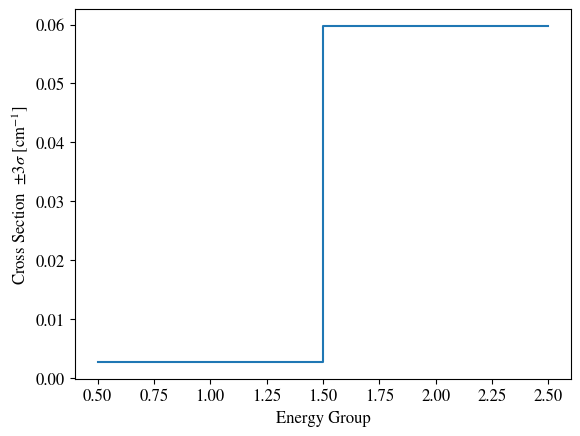

In [17]:
univ0.plot('infFiss')

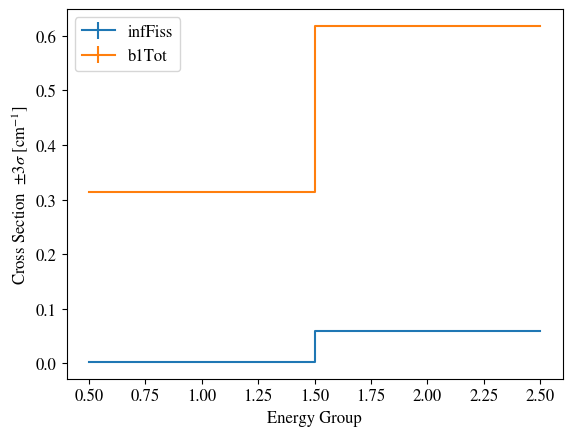

In [18]:
univ0.plot(['infFiss', 'b1Tot'], loglog=False);

The [`ResultsReader` example](http://serpent-tools.readthedocs.io/en/latest/examples/ResultsReader.html#plotting-universes) has a more thorough example of this `plot` method, including formatting the line labels.

## Iteration
The branching reader has a `iterBranches` method that works to yield branch names and their associated `BranchContainer` objects. This can be used to efficiently iterate over all the branches presented in the file.

In [19]:
for names, branch in r0.iterBranches():
    print(names, branch)

('nom', 'nom') <BranchContainer for nom, nom from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('B750', 'nom') <BranchContainer for B750, nom from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('B1000', 'nom') <BranchContainer for B1000, nom from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('nom', 'FT1200') <BranchContainer for nom, FT1200 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('B750', 'FT1200') <BranchContainer for B750, FT1200 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('B1000', 'FT1200') <BranchContainer for B1000, FT1200 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('nom', 'FT600') <BranchContainer for nom, FT600 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>
('B750', 'FT600') <BranchContainer for B750, FT600 from /home/ajohnson400/github/my-serpent-tools/serpentTools/data/demo.coe>


## User Control
The `SERPENT` [`set coefpara`](http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#set_coefpara) card already restricts the data present in the coefficient file to user control, and the `BranchingReader` includes similar control.
Below are the various settings that the `BranchingReader` uses to read and process coefficient files.

* [`branching.floatVariables`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#branching-floatvariables)
* [`branching.intVariables`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#branching-intvariables)
* [`xs.getB1XS`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-getb1xs)
* [`xs.getInfXS`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-getinfxs)
* [`xs.reshapeScatter`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-reshapescatter)
* [`xs.variableExtras`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-variableextras)
* [`xs.variableGroups`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-variablegroups)

In our example above, the `BOR` and `TFU` variables represented boron concentration and fuel temperature, and can easily be cast into numeric values using the [`branching.floatVariables`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#branching-floatvariables) and [`branching.intVariables`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#branching-intvariables) settings. From the previous example, we see that the default action is to store all state data variables as strings.

In [20]:
assert isinstance(b0.stateData['BOR'], str)

As demonstrated in the [Settings example](https://github.com/CORE-GATECH-GROUP/serpent-tools/blob/master/examples/Settings.ipynb), use of  [`xs.variableExtras`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-variableextras) [`xs.variableGroups`](http://serpent-tools.readthedocs.io/en/latest/settingsTop.html#xs-variablegroups)controls what data is stored on the `HomogUniv` objects. By default, all variables present in the coefficient file are stored.

In [21]:
from serpentTools.settings import rc
rc['branching.floatVariables'] = ['BOR']
rc['branching.intVariables'] = ['TFU']
rc['xs.getB1XS'] = False
rc['xs.variableExtras'] = ['INF_TOT', 'INF_SCATT0']
r1 = serpentTools.readDataFile(branchFile)

In [22]:
b1 = r1.branches['B1000', 'FT600']

In [23]:
b1.stateData

{'VERSION': '2.1.29',
 'DATE': '17/12/19',
 'TIME': '09:48:54',
 'BOR': 1000.0,
 'TFU': 600}

In [24]:
assert isinstance(b1.stateData['BOR'], float)
assert isinstance(b1.stateData['TFU'], int)

Inspecting the data stored on the homogenized universes reveals only the variables explicitly requested are present 

In [25]:
univ4 = b1.getUniv('0', 0)
univ4.infExp

{'infTot': array([0.313338, 0.54515 ])}

In [26]:
univ4.b1Exp

{}

## Conclusion
The `BranchingReader` is capable of reading coefficient files created by the `SERPENT` automated branching process. The data is stored according to the branch parameters, universe information, and burnup. This reader also supports user control of the processing by selecting what state parameters should be converted from strings to numeric types, and further down-selection of data.